## <center> **Analyzing A/B Testing Results**

The company plans to launch a new promotion to sell as many tours as possible. The team developed two versions of the landing page of the company's official website and conducted A/B testing. The data collected as a result of the experiment can be found here.

You have to solve a real business problem: to analyze the effectiveness of both variants of the landing page by two criteria at once: purchase conversion and average check. Based on the analysis, you will need to draw conclusions and decide which of the design options is more preferable.

So, our company offers the following tour options and their respective prices:
* Thailand - 100,000 rubles;
* Türkiye - 60,000 rubles;
* Maldives - 200,000 rubles;
* St. Petersburg - 10,000 rubles;
* Kamchatka - 150,000 rubles.

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Study of data

In [61]:
data = pd.read_csv('/Users/Anna/Study/skillfactory/practice/data_practice/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Study of the period of investigation


In [63]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.groupby(['group'])['date'].agg(['max', 'min'])

,max,min
group,,
A,2021-01-24,2021-01-02
B,2021-01-24,2021-01-02


* What is the number of visits to the site in groups A and B?

* What is the total number of purchases in groups A and B?

* What is the sum of all purchases in groups A and B? Give your answer in millions of rubles.

In [64]:
data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index()

,group,user_id,purchase,price
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


Check if there are users who were in both test groups during the A / B test? If yes, how many such unique users, if not, enter 0 in the answer field?

In [65]:
set_a = set(data[data['group']=='A']['user_id'])
set_b = set(data[data['group']=='B']['user_id'])
user_intersection = set_a.intersection(set_b)
len(user_intersection)

1895

Exclusion of users in both groups

In [66]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Initial analysis of A/B testing results

In [67]:
df = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase':'count_purchases', 'price':'sum_price'}) 

Add columns to the grouped table conversion - purchase conversion (the ratio of the number of purchases to the number of site visits in each group, expressed as a percentage) and mean_check - the average check (the ratio of the amount of purchases to the number of purchases in each group).

* What is the conversion in groups? Give your answer as a percentage and round to the nearest hundredth. For example, 75.12%
* What is the average check in groups? Give your answer in rubles and round to the nearest integer. For example, 120519 rubles.

In [68]:
df['conversion'] = round((df['count_purchases']/df['count_visits']*100),2)
df['mean_check'] = round(df['sum_price']/df['count_purchases'])
df

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Comparison of the options for the purchasing power of tours.

In [69]:
df_buy = updated_data.groupby(['group', 'price'])['purchase'].sum().unstack()
df_buy = df_buy.drop([0], axis = 1)
df_buy

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


<AxesSubplot: xlabel='price', ylabel='group'>

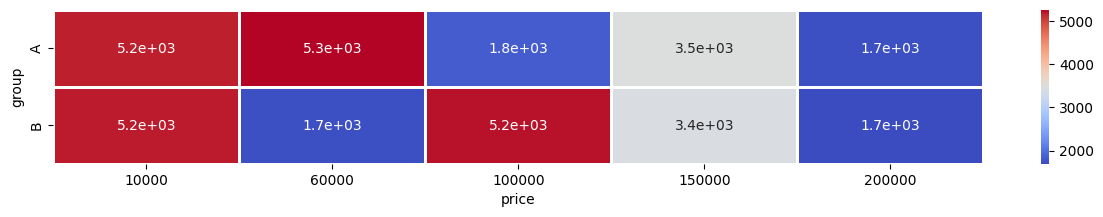

In [70]:
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(df_buy, annot=True, linewidths=.9, ax=ax, cmap='coolwarm')

Preliminary conclusions##
The number of tours sold for 60,000 rubles in group A - 5271, in group B - 1730.
It looks like group A bought cheaper tours, but there is no strong difference.

Group the data by date and testing group. In each group, calculate the number of page visits, the number of purchases, and the amount of purchases.

Add to the table information about the daily conversion (daily number of purchases / daily number of visits) in the group and the daily average check (daily amount of purchases / daily number of purchases)

In [71]:
df_daily = updated_data.groupby(['group', 'date']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index().rename(columns={'user_id': 'count_visits', 'purchase':'count_purchases', 'price':'sum_price'}) 
df_daily['conversion'] = round((df_daily['count_purchases']/df_daily['count_visits']*100),2)
df_daily['mean_check'] = round(df_daily['sum_price']/df_daily['count_purchases'])

In [72]:
df_daily.head()

,group,date,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,2021-01-02,2854,359,29410000,12.58,81922.0
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
2,A,2021-01-04,6566,799,64250000,12.17,80413.0
3,A,2021-01-05,6433,790,64550000,12.28,81709.0
4,A,2021-01-06,6606,764,63410000,11.57,82997.0


In [73]:
exp = df_daily.groupby(['group'])
exp.head()

,group,date,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,2021-01-02,2854,359,29410000,12.58,81922.0
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
2,A,2021-01-04,6566,799,64250000,12.17,80413.0
3,A,2021-01-05,6433,790,64550000,12.28,81709.0
4,A,2021-01-06,6606,764,63410000,11.57,82997.0
23,B,2021-01-02,2861,345,29660000,12.06,85971.0
24,B,2021-01-03,6619,754,65960000,11.39,87480.0
25,B,2021-01-04,6536,764,68030000,11.69,89045.0
26,B,2021-01-05,6511,749,63550000,11.50,84846.0
27,B,2021-01-06,6751,838,75020000,12.41,89523.0


In [74]:
#the conversion on January 3, 2021
df_daily[df_daily['date']=='2021-01-03']['conversion']

1     11.34
24    11.39
Name: conversion, dtype: float64

In [75]:
#the average check on January 3, 2021
df_daily[df_daily['date']=='2021-01-03']['mean_check']

1     82888.0
24    87480.0
Name: mean_check, dtype: float64

Add cumulative signs to the table with daily indicators:
* cumulative number of page visits
* cumulative number of purchases
* cumulative amount of purchases

Calculate the cumulative conversion and the cumulative average check based on the obtained cumulative indicators.

In [76]:
df_daily['cum_visits'] = df_daily.groupby(['group'])['count_visits'].cumsum()
df_daily['cum_purchases'] = df_daily.groupby(['group'])['count_purchases'].cumsum()
df_daily['cum_sum_price'] = df_daily.groupby(['group'])['sum_price'].cumsum()

df_daily['cum_conversion'] = round((df_daily['cum_purchases']/df_daily['cum_visits']*100),2)
df_daily['cum_mean_check'] = round(df_daily['cum_sum_price']/df_daily['cum_purchases'])


In [77]:
#**cumulative** conversion of group B on January 20th
df_daily[(df_daily['date']=='2021-01-20')&(df_daily['group']=='B')]['cum_conversion']

41    11.9
Name: cum_conversion, dtype: float64

In [78]:
#**cumulative** average check in Group A on January 12, 2021
df_daily[(df_daily['date']=='2021-01-12')&(df_daily['group']=='A')]['cum_mean_check']

10    81492.0
Name: cum_mean_check, dtype: float64

Plot cumulative conversion and average check graphs in each group by day.

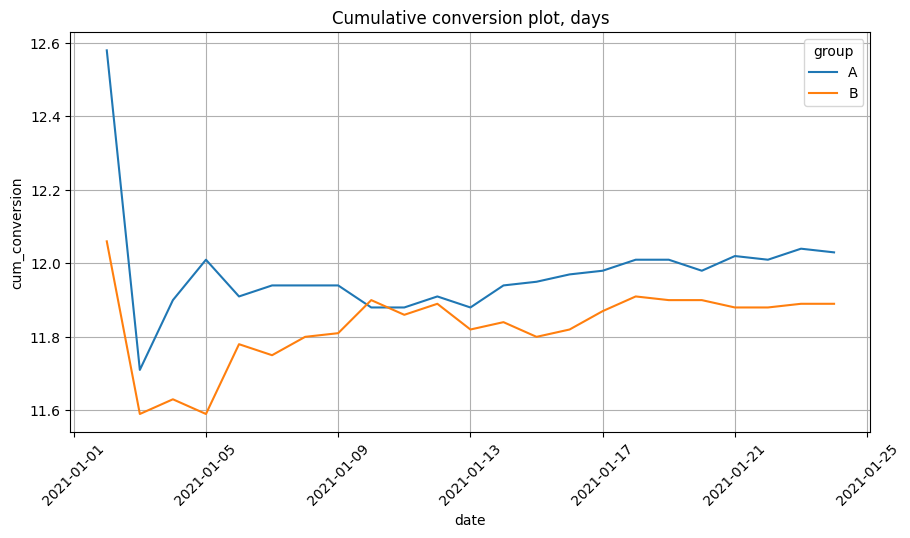

In [79]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=df_daily, hue='group', ax=ax)
ax.set_title('Cumulative conversion plot, days')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

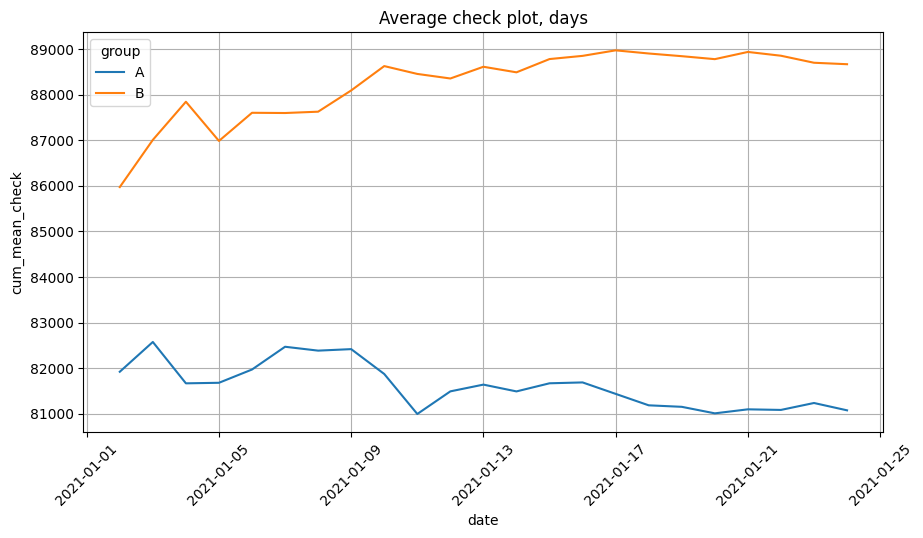

In [80]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_mean_check', data=df_daily, hue='group', ax=ax)
ax.set_title('Average check plot, days')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True);

Preliminary conclusions##
We can say that the data is stable.##
We see almost no difference in conversions and a huge difference in the average check

Statistical analysis

The following null and alternative hypotheses:
* $H_0$: Conversions in groups A and B are equal;
* $H_1$: Group A conversion is greater than group B conversion;

$\alpha$=0.05. 

In [81]:
#p value
from statsmodels.stats import weightstats
_ ,p = weightstats.ztest(df_daily[df_daily['group']=="A"]['conversion'], x2=df_daily[df_daily['group']=="B"]['conversion'], value=0,alternative='two-sided')
print(float(p))

0.21282652662991042


In [82]:
#p value
from scipy.stats import ttest_ind
_ ,p = ttest_ind(df_daily[df_daily['group']=="A"]['conversion'], df_daily[df_daily['group']=="B"]['conversion'], equal_var=True)
p

0.2194196507603395

Conclusions##
No statistical difference

Count a 95% confidence interval for conversions and the difference between them. Use $z_{crit}$ in your calculations

Specify the lower and upper limits of the confidence intervals. Give the boundaries as a percentage and round to 2 decimal places. 

In [83]:
dfa = updated_data[updated_data['group']=="A"]
dfb = updated_data[updated_data['group']=="B"]
dfa.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
4,864975,2021-01-21,A,1,150000
5,936923,2021-01-10,A,0,0
7,719014,2021-01-17,A,0,0


In [84]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma 
    z_crit = -norm.ppf(alpha/2) # z crit
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #sds
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=dfa['user_id'].count(), # sample size
x_p=dfa['purchase'].mean() # sample
)
conf_interval_b = proportions_conf_interval(
n=dfb['user_id'].count(), 
x_p=dfb['purchase'].mean() 
)
print('Confidence interval for group A conversion: {}'.format(conf_interval_a))
print('Confidence interval for group B conversion: {}'.format(conf_interval_b))

Confidence interval for group A conversion: (11.87, 12.2)
Confidence interval for group B conversion: (11.73, 12.06)


In [85]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma 
    diff = xp[1] - xp[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


n = [dfa['user_id'].count(), dfb['user_id'].count()]

xp = [dfa['purchase'].mean(), dfb['purchase'].mean()]

diff_inverval = diff_proportions_conf_interval(n, xp)
print('Confidence interval for conversion difference: {}'.format(diff_inverval))

Confidence interval for conversion difference: (-0.38, 0.09)


Conclusions##
Confidence intervals intersect.##
CI for the difference lies between a negative and a positive number - no difference in conversions

Test the hypothesis about the normal distribution of the daily average check in each of the testing groups.

* What test would you use to test the hypothesis that the distribution of the average daily check is normal?
* What would the null and alternative hypotheses sound like?
* What are the results of the statistical test with the $\alpha$ =0.05 significance level?

In [86]:
alpha = 0.05
#H0 - groups are normally distributed
#H1 - groups are paranormally distributed
shapiro_result_a = shapiro(df_daily[df_daily['group']=='A']['mean_check'])
shapiro_result_b = shapiro(df_daily[df_daily['group']=='B']['mean_check'])
print('p-value group А', round(shapiro_result_a.pvalue, 2))
print('p-value group B', round(shapiro_result_b.pvalue, 2))

p-value group А 0.25
p-value group B 0.09


Conclusions##
Groups are normally distributed

Test under the following null and alternative hypotheses:
* $H_0$: Daily average checks in groups A and B are equal;
* $H_1$: Daily average check in group A is less than in group B;

Calculate the p-value of your test for the daily average check in groups A and B. Compare the resulting p-value with the significance level $\alpha$ =0.05.

In [87]:
from scipy.stats import ttest_ind
_ ,p = ttest_ind(df_daily[df_daily['group']=="A"]['mean_check'], df_daily[df_daily['group']=="B"]['mean_check'], equal_var=True)
round(p,2)

0.0

Conclusions##
The p value tends to 0, which means there is a statistical difference

Count a 95% confidence interval for the average check in each group. Since the sample of average checks is small, use $t_{crit}$ in your calculations.

Specify the lower limit of the confidence interval for the true average check of each of the groups. Give your answer as a percentage and round to the nearest whole number.

In [88]:
from scipy.stats import t

dfa_t = df_daily[df_daily['group']=='A']
dfb_t = df_daily[df_daily['group']=='B']

def proportions_conf_interval_t(n, x_p, std, gamma=0.95): 
    alpha = 1 - gamma 
    k=n-1
    t_crit = -t.ppf(alpha/2,k) 
    eps = t_crit * std/(n ** 0.5) 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    confidence_interval = (round(lower_bound), round(upper_bound))
    return confidence_interval

conf_interval_a_t = proportions_conf_interval_t(
x_p=dfa_t['mean_check'].mean(), 
n=dfa_t['date'].count(),
std = dfa_t['mean_check'].std()
)

conf_interval_b_t = proportions_conf_interval_t(
x_p=dfb_t['mean_check'].mean(), 
n=dfb_t['date'].count(),
std = dfb_t['mean_check'].std() 
)

print('Confidence interval for group A conversion: {}'.format(conf_interval_a_t))
print('Confidence interval for group B conversion: {}'.format(conf_interval_b_t))

Confidence interval for group A conversion: (79630, 82308)
Confidence interval for group B conversion: (87626, 89526)


Conclusions##
There are no intersections, which means that we can assume that in group B the average check is actually higher

## **Main conclusions on A/B test**


The analysis showed that the design does not affect the number of purchases, however, it increases the likelihood of buying expensive tours, which can be seen in the frequency of buying expensive tours and a decent difference in the average check